In [283]:
import pandas as pd
from utilities import clean_data, missing, derivatives_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [284]:
df, df_brands, df_allbrands, brands, compsets, compset_groups, groups_bycompset = clean_data()

In [285]:
df_rate, df_curvature = derivatives_data(df)

In [286]:
corr_mat = df.corr()
corr_mat_rate = df_rate.corr()
corr_mat_curv = df_curvature.corr()

df_concatenated = pd.concat([df, df_rate, df_curvature], axis=1)

# Compute the correlation matrix
correlation_matrix = df_concatenated.corr()

Here we correlate all parameters with each other.
Notable correlations are 
- change in followers with the curvature of followers
- weekly number of videos and pictures
- weekly number of likes and number of followers

Open questions:
For which companies are those correlations the highest?

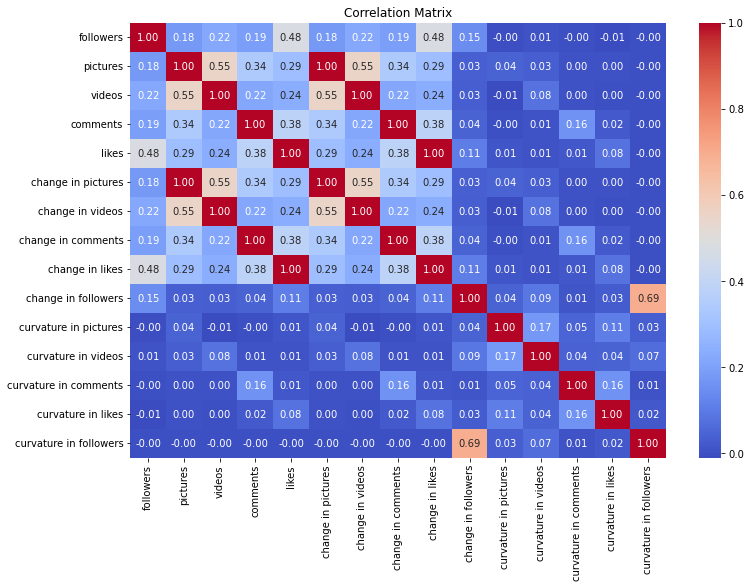

In [287]:
# Plot the heatmaps
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [288]:
df_rate_plots = df_rate.copy()
df_rate_plots['period_end_date'] = pd.to_datetime(df_rate_plots['period_end_date'])

df_curvature_plots = df_curvature.copy()
df_curvature_plots['period_end_date'] = pd.to_datetime(df_curvature_plots['period_end_date'])

companies = df_rate_plots['business_entity_doing_business_as_name'].unique()

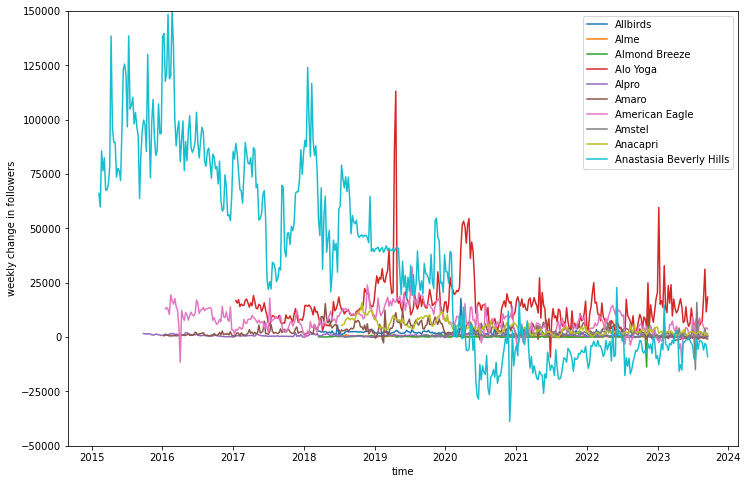

In [289]:
plt.figure(figsize=(12,8))
for company in companies[20:30]:
    index = df_rate_plots['business_entity_doing_business_as_name'] == company
    plt.plot(df_rate_plots.loc[index, 'period_end_date'][5:], df_rate_plots.loc[index, 'change in followers'][5:], 
             label=company)
plt.ylim(-50000,150000)
plt.xlabel('time')
plt.ylabel('weekly change in followers')
plt.legend()
plt.show()

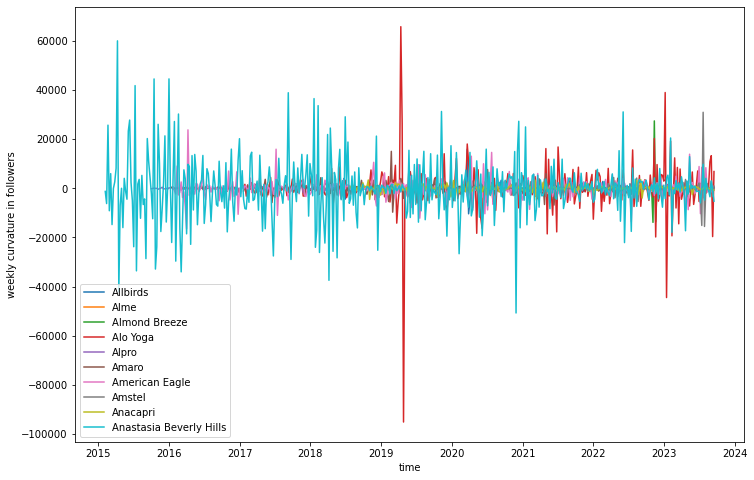

In [290]:
plt.figure(figsize=(12,8))
for company in companies[20:30]:
    index = df_rate_plots['business_entity_doing_business_as_name'] == company
    plt.plot(df_curvature_plots.loc[index, 'period_end_date'][5:], df_curvature_plots.loc[index, 'curvature in followers'][5:], 
             label=company)
#plt.ylim(-50000,150000)
plt.xlabel('time')
plt.ylabel('weekly curvature in followers')
plt.legend()
plt.show()

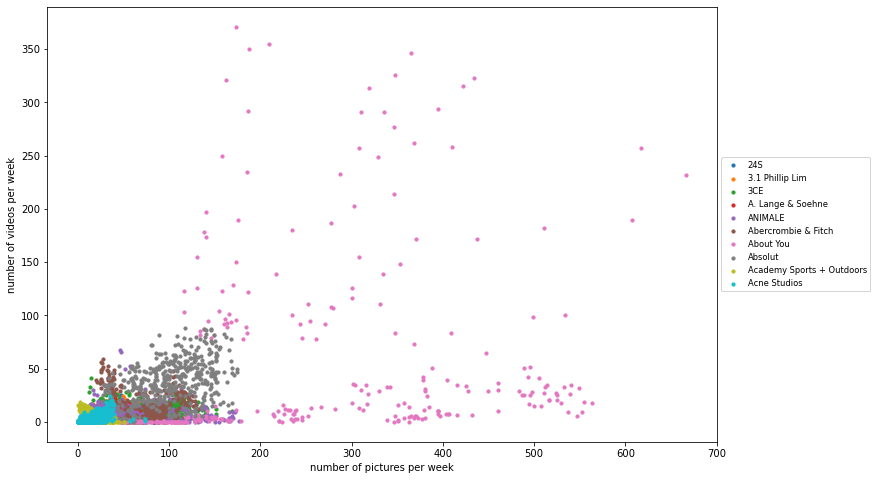

In [292]:
plt.figure(figsize=(12,8))
for company in companies[:10]:
    index = df_rate_plots['business_entity_doing_business_as_name'] == company
    #df_rate_filtered = df_rate_plots[(df_rate_plots != 0).all(axis=1)]
    #df_curv_filtered = df_curvature_plots[(df_rate_plots != 0).all(axis=1)]
    plt.scatter(df_rate_plots.loc[index, 'change in pictures'], df_rate_plots.loc[index, 'change in videos'],
         label=company, s=10)
plt.xlabel('number of pictures per week')
plt.ylabel('number of videos per week')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=math.ceil(len(brands_by_cgroup[cgroup])/30))

plt.show()

change in likes over 4 weeks against change in followers

In [293]:
brands_by_cgroup = {} # dict: list of brands contained in each compset_group
for group in compset_groups:
    brands_by_cgroup[group] = df_brands[df_brands['compset_group'] == group][
        'business_entity_doing_business_as_name'].tolist()

cgroup_ranking = {cgroup: df[df['business_entity_doing_business_as_name'].isin(brands_by_cgroup[cgroup])] for cgroup in compset_groups}
compset_groups = df_brands['compset_group'].unique()


In [294]:
import math

In [295]:
brands_by_cgroup = {} # dict: list of brands contained in each compset_group
for group in compset_groups:
    brands_by_cgroup[group] = df_brands[df_brands['compset_group'] == group][
        'business_entity_doing_business_as_name'].tolist()

cgroup_ranking = {cgroup: df_rate[df_rate['business_entity_doing_business_as_name'].isin(brands_by_cgroup[cgroup])] for cgroup in compset_groups}
compset_groups = df_brands['compset_group'].unique()

It looks as though the correlation of two parameters for different lags generally follows a larger trend within a compset_group. We can exploit this feature to find outliers deviating significantly from the large-scale trends (for large enough groups).

In an example we shall focus on the group Restaurants

In [296]:
app_ret_correlation = []
df_corr = pd.DataFrame()
cgroup = 'Restaurants'

for brand, data in cgroup_ranking[cgroup].groupby('business_entity_doing_business_as_name'):
    app_ret_correlation = []
    for lag in range(-8, 8):
        app_ret_correlation.append(data['change in likes'].corr(data['change in followers'].shift(lag)))
    
    # Create a temporary DataFrame for the current brand
    df_brand = pd.DataFrame({
        'correlation': app_ret_correlation,
        'lag': np.arange(-8, 8),
        'brand': brand
    })
    
    # Append the data for the current brand to the main DataFrame
    df_corr = pd.concat([df_corr, df_brand], ignore_index=True)

In [297]:
#normalize the curves by dividing by the mean correlation and looking whether the curve deviates significantly by 1
df_corr_normalized = df_corr.copy()
# Calculate the mean correlation for each lag across all companies
mean_corrs = df_corr.groupby('lag')['correlation'].mean()
# Normalize and shift the correlation values for each company
for brand in df_corr_normalized['brand'].unique():
    for lag in df_corr_normalized['lag'].unique():
        # Normalize the correlation values by the mean correlation for the lag across all companies
        df_corr_normalized.loc[(df_corr_normalized['lag'] == lag) & (df_corr_normalized['brand'] == brand), 'correlation'] /= mean_corrs[lag]
    # Shift the correlation values by their own mean to center them around y = 0
    df_corr_normalized.loc[df_corr_normalized['brand'] == brand, 'correlation'] -= df_corr_normalized.loc[df_corr_normalized['brand'] == brand, 'correlation'].mean()

In [298]:
from scipy.ndimage import gaussian_filter1d

sigma = 2
# Create a copy of the DataFrame for smoothed values
df_corr_smoothed = df_corr_normalized.copy()

# Smooth the correlation values for each brand separately
for brand in df_corr_normalized['brand'].unique():
    # Extract correlation values for the current brand
    brand_data = df_corr_normalized[df_corr_normalized['brand'] == brand]
    # Smooth the correlation values using Gaussian filter
    smoothed_values = gaussian_filter1d(brand_data['correlation'], sigma)
    # Update the DataFrame with the smoothed values
    df_corr_smoothed.loc[df_corr_smoothed['brand'] == brand, 'correlation'] = smoothed_values


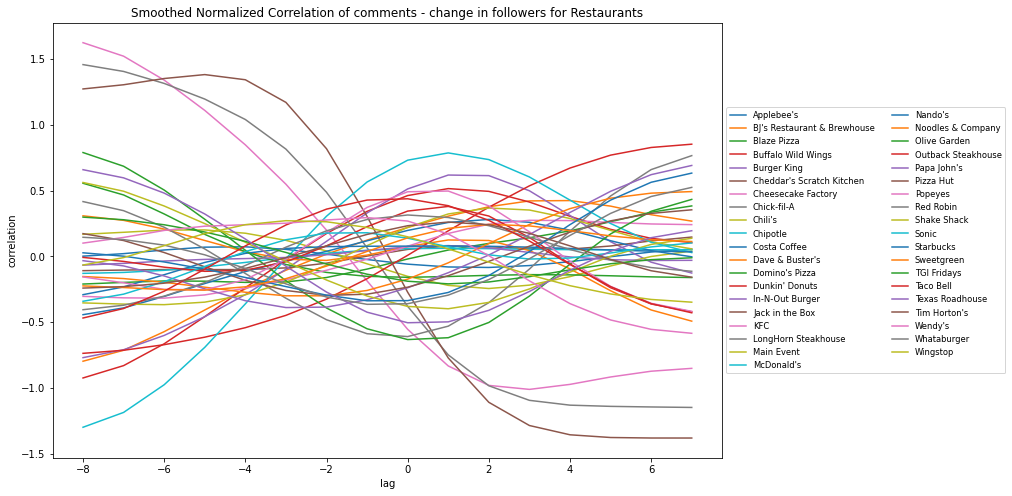

In [299]:
plt.figure(figsize=(12,8))
for brand in df_corr_normalized['brand'].unique():
    plt.plot(range(-8,8), df_corr_smoothed.loc[df_corr_smoothed['brand'] == brand, 'correlation'], label = brand)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=math.ceil(len(brands_by_cgroup[cgroup])/30))
plt.title('Smoothed Normalized Correlation of comments - change in followers for Restaurants')
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

Lets look at a different group -> Outdoor Gear

In [300]:
app_ret_correlation = []
df_corr = pd.DataFrame()
cgroup = 'Outdoor Gear'

for brand, data in cgroup_ranking[cgroup].groupby('business_entity_doing_business_as_name'):
    app_ret_correlation = []
    for lag in range(-8, 8):
        app_ret_correlation.append(data['change in likes'].corr(data['change in followers'].shift(lag)))
    
    # Create a temporary DataFrame for the current brand
    df_brand = pd.DataFrame({
        'correlation': app_ret_correlation,
        'lag': np.arange(-8, 8),
        'brand': brand
    })
    
    # Append the data for the current brand to the main DataFrame
    df_corr = pd.concat([df_corr, df_brand], ignore_index=True)

In [301]:
#normalize the curves by dividing by the mean correlation and looking whether the curve deviates significantly by 1
df_corr_normalized = df_corr.copy()
# Calculate the mean correlation for each lag across all companies
mean_corrs = df_corr.groupby('lag')['correlation'].mean()
# Normalize and shift the correlation values for each company
for brand in df_corr_normalized['brand'].unique():
    for lag in df_corr_normalized['lag'].unique():
        # Normalize the correlation values by the mean correlation for the lag across all companies
        df_corr_normalized.loc[(df_corr_normalized['lag'] == lag) & (df_corr_normalized['brand'] == brand), 'correlation'] /= mean_corrs[lag]
    # Shift the correlation values by their own mean to center them around y = 0
    df_corr_normalized.loc[df_corr_normalized['brand'] == brand, 'correlation'] -= df_corr_normalized.loc[df_corr_normalized['brand'] == brand, 'correlation'].mean()

In [302]:
sigma = 2
# Create a copy of the DataFrame for smoothed values
df_corr_smoothed = df_corr_normalized.copy()

# Smooth the correlation values for each brand separately
for brand in df_corr_normalized['brand'].unique():
    # Extract correlation values for the current brand
    brand_data = df_corr_normalized[df_corr_normalized['brand'] == brand]
    # Smooth the correlation values using Gaussian filter
    smoothed_values = gaussian_filter1d(brand_data['correlation'], sigma)
    # Update the DataFrame with the smoothed values
    df_corr_smoothed.loc[df_corr_smoothed['brand'] == brand, 'correlation'] = smoothed_values

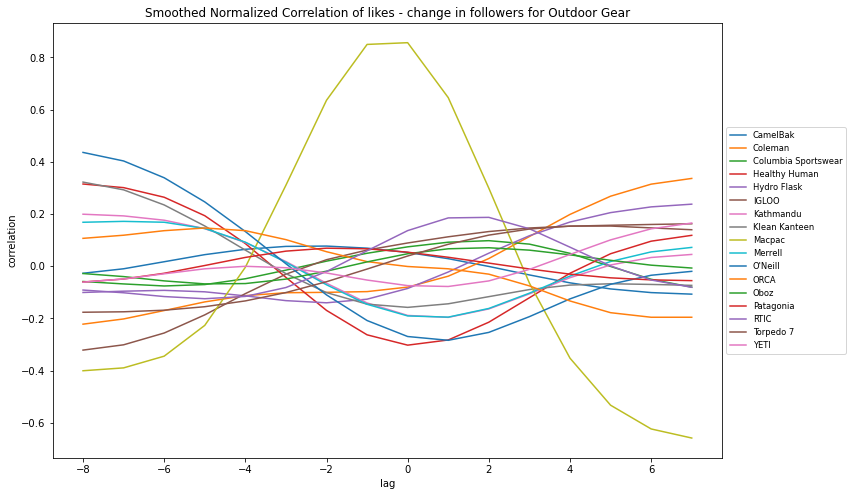

In [303]:
plt.figure(figsize=(12,8))
for brand in df_corr_smoothed['brand'].unique():
    plt.plot(range(-8,8), df_corr_smoothed.loc[df_corr_smoothed['brand'] == brand, 'correlation'], label = brand)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small', ncol=math.ceil(len(brands_by_cgroup[cgroup])/30))
plt.title('Smoothed Normalized Correlation of likes - change in followers for Outdoor Gear')
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()